In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import sys
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data preparation

In [4]:
from dataset import create_dataset, remove_rare_chars, split_data
DATA_PATH = '../../Dataset/trdg'
FONT_PATH = '../../Dataset/NomNaTong-Regular.ttf'

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATA_PATH)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=2)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs, sep='')

Number of images found: 3487
Number of labels found: 3487
Number of unique characters: 2161
Characters present:{'㐌': 316, '浪': 300, '朱': 247, '\U000f047c': 214, '\U000f070b': 213, '尼': 210, '吏': 200, '𦋦': 197, '𢚸': 197, '娘': 197, '𠊛': 192, '固': 189, '拱': 172, '之': 167, '情': 161, '埃': 161, '買': 151, '芇': 146, '𠬠': 145, '仙': 139, '欺': 138, '群': 136, '𠳒': 136, '麻': 130, '𠓨': 127, '𧗱': 124, '爫': 122, '別': 118, '塘': 117, '花': 114, '𠫾': 109, '𠄩': 108, '払': 106, '渚': 106, '𡗶': 106, '浽': 104, '傷': 103, '強': 102, '呐': 101, '渃': 99, '𦖑': 99, '饒': 97, '庒': 97, '如': 96, '些': 95, '分': 94, '冲': 94, '畧': 93, '咍': 92, '鐄': 90, '時': 90, '昆': 90, '低': 90, '𢬣': 89, '𡢐': 88, '身': 87, '兜': 87, '𧡊': 86, '於': 86, '細': 84, '生': 81, '月': 79, '公': 78, '戈': 78, '皮': 78, '調': 76, '﨤': 74, '𣈜': 74, '爲': 73, '茹': 73, '沛': 73, '牢': 73, '仍': 73, '油': 73, '命': 72, '排': 70, '典': 66, '包': 66, '娥': 65, '碎': 65, '㗂': 64, '\U000f061a': 63, '雲': 62, '𠁀': 61, '\U000f02c7': 61, '恩': 61, '迻': 59, '耒': 59, '茄': 57, '共': 57, '紅'

## Dataset splitting

In [6]:
x_train, x_valid, y_train, y_valid = split_data(img_paths, labels)
x_valid, x_test, y_valid, y_test = split_data(x_valid, y_valid, train_size=0.5)

print('Total training samples:', len(x_train))
print('Total validation samples:', len(x_valid))
print('Total testing samples:', len(x_test))

Total training samples: 3138
Total validation samples: 174
Total testing samples: 175


## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

## Preprocessing

In [8]:
from image_pipeline import preprocess_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
HEIGHT = 148
WIDTH = 32

In [9]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = preprocess_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

## Prepare `tf.data.Dataset` objects

In [10]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [11]:
train_tf_dataset = prepare_tf_dataset(x_train, y_train)
valid_tf_dataset = prepare_tf_dataset(x_valid, y_valid)
test_tf_dataset = prepare_tf_dataset(x_test, y_test)
train_tf_dataset

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'label_length': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

## Visualize the data

In [12]:
from matplotlib.font_manager import FontProperties
NROWS, NCOLS = (2, 8)
assert NROWS * NCOLS <= BATCH_SIZE, f'NROWS * NCOLS must be <= {BATCH_SIZE}'
fontdict = {
    'fontproperties': FontProperties(fname=FONT_PATH),
    'fontsize': 18,
    'color': 'black',
    'verticalalignment': 'top',
    'horizontalalignment': 'left'
}

In [13]:
def visualize_batch(
    batch_images, batch_labels, pred_texts=None,
    batch_size=BATCH_SIZE, nrows=NROWS, ncols=NCOLS
):
    for i in range(min(nrows * ncols, batch_size)):
        plt.subplot(nrows, ncols, i + 1)
        img = (batch_images[i] * 255.0).numpy().astype('uint8')
        plt.imshow(img[:, :, 0], cmap='gray')

        # Gather indices where label != padding_token.
        indices = tf.gather(
            batch_labels[i], 
            tf.where(tf.math.not_equal(batch_labels[i], PADDING_TOKEN))
        )
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        label = label.numpy().decode('utf-8')
        
        if pred_texts: draw_predicted_text(pred_texts, label, i) # Defined below
        else: plt.text(WIDTH + 3, 0, '\n'.join(label), fontdict=fontdict)
        fontdict['color'] = 'black' # Reset the color
        plt.axis('off')

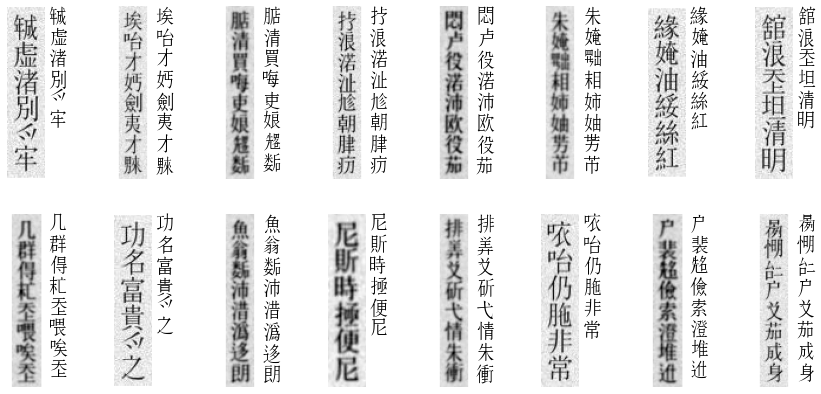

In [14]:
for batch in train_tf_dataset.take(1):
    plt.figure(figsize=(15, 7))
    batch_images, batch_labels = batch['image'], batch['label']
    visualize_batch(batch_images, batch_labels)

# Define the model

In [15]:
from ctc import CTCLayer
from cnn import custom_cnn, imagenet_model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [23]:
image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
label_input = Input(shape=(None,), dtype='int64', name='label')
label_length = Input(shape=[1], dtype='int64', name='label_length')

## CNN layers
conv_blocks_config = {
    'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
    'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
    'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
    'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
}
x = custom_cnn(conv_blocks_config, image_input)

# RNN layers
bigru_layers = [512, 512]
for idx in range(len(bigru_layers)):
    x = Bidirectional(GRU(
        units = bigru_layers[idx], 
        return_sequences = True, 
        dropout = 0.2,
    ), name = f'bigru{idx + 1}')(x)

# Output layer
y_pred = Dense(
    units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC
    activation = 'softmax', 
    name = 'rnn_output'
)(x)

# Compile the model and return
model = Model(
    inputs = [image_input, label_input, label_length], 
    outputs = CTCLayer()(label_input, y_pred, label_length), 
    name = 'CRNN_OCR'
)

model.compile(optimizer=Adam(learning_rate=2e-4))
model.summary(line_length=100)     

Model: "CRNN_OCR"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                         

# Callbacks

In [24]:
from tensorflow.train import CheckpointOptions
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, 
    LearningRateScheduler, ReduceLROnPlateau
)
from edit_distance import EditDistanceCallback

In [25]:
# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = 'checkpoints/cp-{epoch:03d}.ckpt', 
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * len(x_train) // BATCH_SIZE, 
    options = options,  
    verbose = 1
)

In [26]:
def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

In [27]:
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5, # Stop if no improvement after 5 epochs
    min_delta = 0.0001, # The val_loss should at least improve 0.0001
    restore_best_weights = True, 
    verbose = 1
)

# Edit Distance is the most widely used metric to evaluate OCR models
edit_distance_callback = EditDistanceCallback(
    Model(inputs=image_input, outputs=y_pred), 
    valid_tf_dataset, 
    MAX_LENGTH
) 

# Training

In [28]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = 100,
    callbacks = [
#         checkpoint_callback,
#         schedule_lr_callback, 
        reduce_lr_callback, 
        edit_distance_callback, 
        early_stopping_callback,
    ],
    verbose = 1
)
model.save('crnn.h5')

Epoch 1/100
197/197 [==============================] - 12s 40ms/step - loss: 51.2143 - val_loss: 57.9706 - lr: 2.0000e-04
Epoch 2/100
197/197 [==============================] - 6s 29ms/step - loss: 43.3339 - val_loss: 43.4748 - lr: 2.0000e-04
Epoch 3/100
197/197 [==============================] - 6s 29ms/step - loss: 27.2494 - val_loss: 21.8296 - lr: 2.0000e-04
Epoch 4/100
197/197 [==============================] - 6s 30ms/step - loss: 13.2435 - val_loss: 14.0925 - lr: 2.0000e-04
Epoch 5/100
197/197 [==============================] - 6s 31ms/step - loss: 6.9978 - val_loss: 12.8321 - lr: 2.0000e-04
Epoch 6/100
197/197 [==============================] - 6s 30ms/step - loss: 3.8904 - val_loss: 9.0195 - lr: 2.0000e-04
Epoch 7/100
197/197 [==============================] - 6s 31ms/step - loss: 2.1745 - val_loss: 6.9895 - lr: 2.0000e-04
Epoch 8/100
197/197 [==============================] - 6s 30ms/step - loss: 1.1934 - val_loss: 6.0108 - lr: 2.0000e-04
Epoch 9/100
197/197 [=================

Epoch 38/100
197/197 [==============================] - 7s 33ms/step - loss: 0.0103 - val_loss: 3.6746 - lr: 5.0000e-05
Epoch 39/100
197/197 [==============================] - 6s 33ms/step - loss: 0.0100 - val_loss: 3.6680 - lr: 5.0000e-05
Epoch 40/100
197/197 [==============================] - 6s 31ms/step - loss: 0.0098 - val_loss: 3.6721 - lr: 5.0000e-05
Epoch 41/100
195/197 [============================>.] - ETA: 0s - loss: 0.0095
Epoch 41: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.6712662
197/197 [==============================] - 6s 30ms/step - loss: 0.0095 - val_loss: 3.7277 - lr: 5.0000e-05
Epoch 42/100
197/197 [==============================] - 6s 30ms/step - loss: 0.0093 - val_loss: 3.6261 - lr: 2.5000e-05
Epoch 43/100
197/197 [==============================] - 6s 31ms/step - loss: 0.0091 - val_loss: 3.6217 - lr: 2.5000e-05
Epoch 44/100
197/197 [==============================] - 6s 30ms/step - loss: 0.0090 - val_loss: 3.6395 -

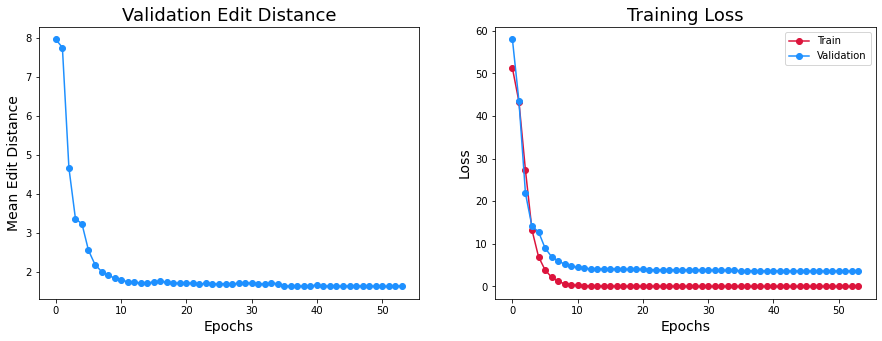

In [29]:
fig = plt.figure(figsize=(15, 5))
loss, val_loss = history.history['loss'], history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(edit_distance_callback.logs, linestyle='solid', marker='o', color='dodgerblue')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Mean Edit Distance',fontsize=14)
plt.title('Validation Edit Distance', fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(loss, linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(val_loss, linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Training Loss', fontsize=18)
plt.legend(loc='best')

fig.savefig('crnn_history.png', bbox_inches='tight') 
plt.show()

# Inference

In [43]:
from matplotlib.patches import Patch
from tensorflow.keras.models import load_model
from ctc import decode_batch_predictions

## Reload the model

In [31]:
reloaded_model = load_model('crnn.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "CRNN_OCR"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                         

## Function to draw each predicted character

In [32]:
mpatches_handles = [
    Patch(color='green', label='Full match'), 
    Patch(color='dodgerblue', label='Character match'),
    Patch(color='red', label='Wrong prediction'),
    Patch(color='black', label='Actual character'),
    Patch(color='gray', label='Missing position'),
]

In [33]:
def draw_predicted_text(pred_texts, label, image_idx):
    text, pos_x = pred_texts[image_idx], WIDTH + 3
    label = label.replace('[UNK]', ' ?')
    
    if text != label: 
        start, end = 0, 0
        while start <= end < len(label):
            pos_y = end * 18.5
            if label[start:end+1] in text:
                fontdict['color'] = 'dodgerblue'
                plt.text(pos_x, pos_y, label[end], fontdict=fontdict)
            else: 
                if end + 1 < len(label) and text[end] == label[end + 1]:
                    fontdict['color'] = 'gray'
                    plt.text(pos_x, pos_y, label[end], fontdict=fontdict)
                else:
                    fontdict['color'] = 'red'
                    plt.text(pos_x, pos_y, text[end], fontdict=fontdict)
                    fontdict['color'] = 'black'
                    actual_char = '[UNK]' if label[end] == '?' else label[end]
                    plt.text(pos_x + 20, pos_y, actual_char, fontdict=fontdict)
                start = end + 1
            end += 1
    else: 
        fontdict['color'] = 'green'
        plt.text(pos_x, 0, '\n'.join(text), fontdict=fontdict)

## On test dataset

Batch 1: ['埃探䀡幅像夫', '包饒拱閉饒錢秩之', '共饒計礼𡢐初', '𧵑尼爫\U000f0482𠸗恩払', '歲尼買𠹾母䘮扵𠇮', '𢬣揞幅像哭𣳔如湄', '交朱固状默筭法刑', '童浪碎㐌卢賖', '哙戈𠸜户𠬠欺朱詳', '姅𢜠姅吏𢜝台', '﨤欺焒覩牟強添稽', '嗔蹺拱妾𡊰恩朱払', '云仙群唉囬鄕咏茄', '苦油𠦳淡塘車拱仃', '媄昆碎細𦋦侯状元', '特𠳒媒買論機']

Batch 2: ['𢭮𢝙𢭮曲断膓\U000f000e之', '底娘朱典浽尼爲碎', '吹𠊚固俸𦝄清', '柳油分妾圖流連', '𣈙昆𠖈准風\U000f0870', '卞𤼸\U000f070b礼賒珠𡬷誠', '𢬣捞渃𬑉𨀈𦋦', '𦖻𦖑㗂呐請台', '𠬠交𠄩册麻𠀧\U000f0482重', '傷払分泊於𠁀', '固𠊚聀奇嵬高', '忍还翁買𤑟𧗱吏勸', '状元𡎢𥄮月娥', '共饒𨇍𨀈𠁑楼', '𠁑花㐌𧡊固払𨅸𬖉', '欺𣎀𦣰𧡊佛\U000f070f']

Batch 3: ['㝵𠸗𡮈案苔𠫾', '渃㵢花用㐌安', '別包𧊉𣳮蜂淶', '䏾朝㐌我𨤮愧群賒', '𦹵\U000f0607\U000f061a坦碁封𨁪粧', '㐌\U000f077a顕馬朱\U000f03d9', '𠓀柴𡢐伵㖔癡', '吏\U000f0761各路拍園侯查', '嗔迻𦊚𥛉仕排源干', '戈䀡\U000f061a倍踈之㐌仃', '月娥𠓨達礼\U000f0029産床', '𡛔辰節行\U000f047c句排𨉓', '粉乘香𡳵倍分悴車', '悲徐都𠖈本鄕', '清明𥪞節𣎃𠀧', '冲𢚸它恪拱爲虎台']



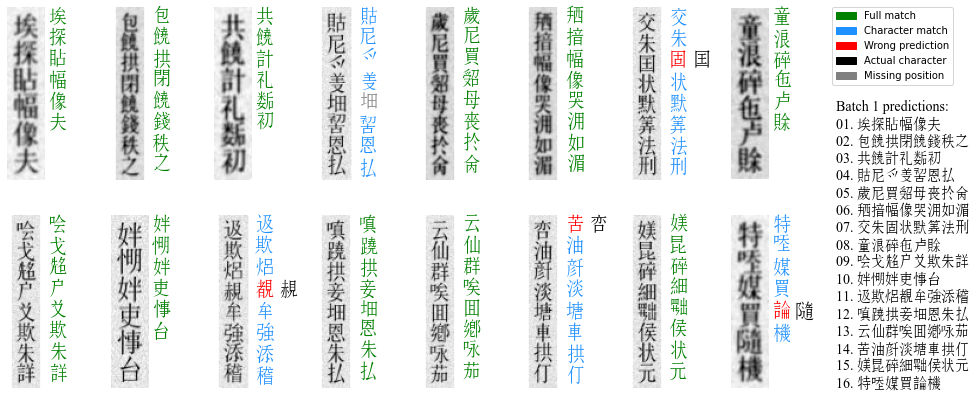

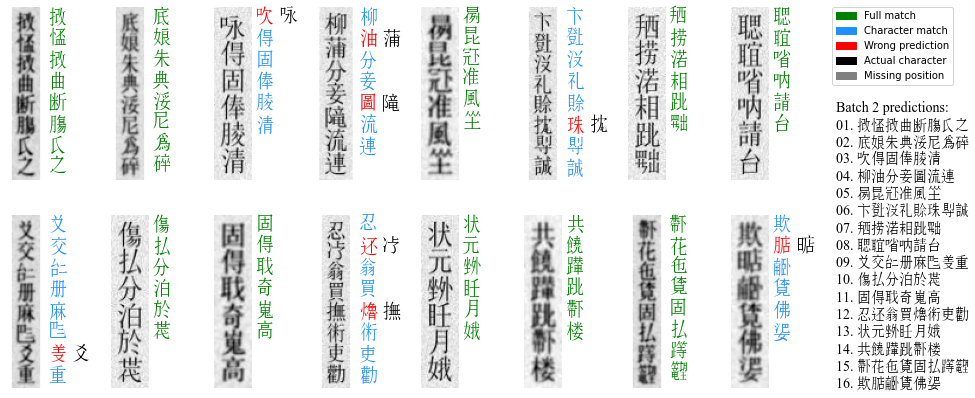

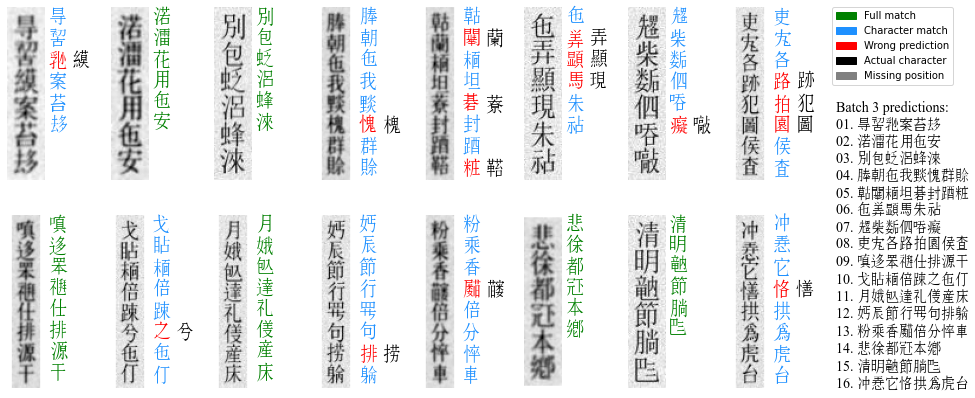

In [45]:
for idx, batch in enumerate(test_tf_dataset.take(3)):
    batch_images, batch_labels = batch['image'], batch['label']
    preds = reloaded_prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, MAX_LENGTH, 50, num2char)
    
    plt.figure(figsize=(15, 7))
    plt.subplots_adjust(left=0, right=0.75)        
    visualize_batch(batch_images, batch_labels, pred_texts)
    
    plt.legend(handles=mpatches_handles, loc=(2.7, 1.75))
    annotate_text = [f'{idx + 1:02d}. {text}' for idx, text in enumerate(pred_texts)]
    plt.annotate(
        f"Batch {idx + 1} predictions:\n{chr(10).join(annotate_text)}", 
        fontproperties = FontProperties(fname=FONT_PATH),
        xycoords = 'axes fraction', 
        fontsize = 14, 
        xy = (2.8, 0), 
    )
    print(f'Batch {idx + 1}:', pred_texts, end='\n\n')

## On random image

Predicted text: 大越史𠄩全書


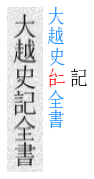

In [46]:
random_image = process_images_labels('../大越史記全書.jpg', '大越史記全書')
batch_images = tf.expand_dims(random_image['image'], axis=0)
batch_labels = tf.expand_dims(random_image['label'], axis=0)

preds = reloaded_prediction_model.predict(batch_images)
pred_texts = decode_batch_predictions(preds, MAX_LENGTH, 50, num2char)
visualize_batch(batch_images, batch_labels, pred_texts, 1, 1)
print('Predicted text:', ''.join(pred_texts))